# Fundamentals of Social Data Science
# Week 4 Day 2. Network Analysis 

In this lab I demonstrate three different approaches to creating networks of users from subreddits. These can be used in order to represent user interaction data as a network. Each network will represent the data in slightly different way and can be considered as such. Interestingly, these are all created from the same table of comments. 

We first create our list of posts as before. But this time around we then go to each story and collect the comments. Please note that this is not a full set of comments for any given story but the comments that Reddit would show when you go to that page. That is, it does not include comments buried under 'more comments'. But with a list of comments we can create these networks below: 

1. **Threaded networks**. `create_comment_tree`: Each post will be a single meta-thread. That is it is really a series of threads but if we say root=True then it will create a node for the post and then connect all the nodes to that post. We can look to metrics like 'geodesic' in networks to collect the deepest or widest thread and compare across posts. Explore thread depth or width to describe a subreddit or a post.
2. **User-interaction networks**. `create_user_interaction_network(comments_df)`: While we have posts, these have authors. So an author can reply to someone more than once or people can reply to each other. So if we build a network around who replies to whom rather than which post replies to which post, we no longer have a tree structure. But do we have a dense core? Do we have many different components or one big component (i.e. everyone replying to everyone else).
3. **Bipartite networks**. `create_user_post_network(comments_df)`: We can explore which users share a sub in common or which subs share users in common. These can be seen as a bipartite (i.e. two separate side ) network. In social network analysis is this often also called a two-mode network. 

Today, you're encouraged to play with the parameters below. What if we download more posts? Do you find that the user-interaction network is very clustered or a big hairball of replies? These structures help build intuition though they may or may not be easy to directly integrate in any analysis of your topic. Nonetheless, I hope that networks helps you think about how to appreciate data at scale and potentially provides a new framework for approaching relations between people, social structure, and social data science questions more broadly.

You are welcome to tweak the code as you see fit. This lab is much like the earlier t-SNE lab in that you are encouraged to explore and see what patterns seem coherent to you. Confirmatory statistics with networks are very tricky but descriptive statistics and inductive insights are readily available. 

Note that the `get_post_comments` does not have a caching function. You may consider caching or other ways to store the user data rather than redownloading it. Also, consider that because we are trying to leave a light footprint on Reddit, this code sleeps for 2 second between requests. Finally, notice that now we have a more general RedditScraper. The only real difference is that we have a "sort" parameter so you can sort by 'top' or 'new'. 

These exercises are optional but should guide your consideration. 

**Exercise 1**. Visualize the comment structore of 5 top stories from a subreddit of choice. **(Done)**

**Exercise 2**. Create a Jaccard similarity score for three posts based on their overlap in users in the comments. **(Done)**

**Exercise 3**. How might you create a plot where the nodes are sized differently depending on centrality? Why can't we just take raw scores for the size (hint, it will make nodes very tiny). **(Done)**

**Exercise 4**. Consider why cosine similarity might make sense. In this case, try Eucliean and Jaccard as well to consider their own respective logic. Euclidean will likely find users who are positionally central where cosine should find users who are positionally similar. 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from matplotlib import pyplot as plt
import networkx as nx
from utils.network_builder import *
from utils.analysis import *
import time

In [2]:
# 1. Get the top 3 posts from a subreddit
posts, comments_df = get_comments_df("AskMen", "top", USER_AGENT, 3)



Posts fetched
Fetching comments from https://api.reddit.com/comments/1gl5i9p
Fetching comments from https://api.reddit.com/comments/1gl8zus
Fetching comments from https://api.reddit.com/comments/1glbxkd


The maximum width of the tree is: 80
The width of the tree at the first level is: 80
Depth of the tree: 7


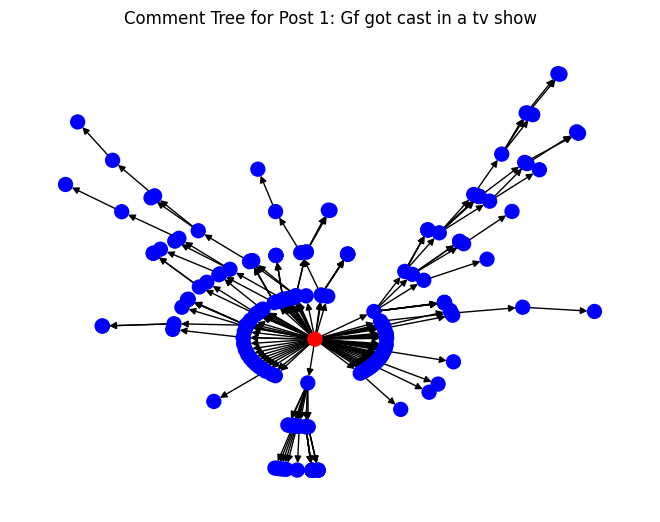

In [6]:
# 1) Threaded network

# Comment tree for post 1
plt.figure()
post_1_comments = comments_df[comments_df['post_id'] == posts[0]['id']] # get the comments for post 1
comment_tree_1 = usercomment_tree(post_1_comments, include_root=True) # create the comment tree
pos_tree_1 = nx.kamada_kawai_layout(comment_tree_1) # get the positions of the nodes (kamada_kawai_layout aesthetically spaces the nodes while preserving the structure of the graph
nx.draw(comment_tree_1, pos_tree_1, node_size=100,  # draw the comment tree
        node_color=['red' if d['type']=='post' else 'blue' 
                   for _, d in comment_tree_1.nodes(data=True)])
plt.title(f"Comment Tree for Post 1: {posts[0]['title']}") # set the title of the plot

# Calculate max width of the tree
print(f"The maximum width of the tree is: {max(calculate_tree_width(comment_tree_1).values())}")

print(f"The width of the tree at the first level is: {calculate_tree_width(comment_tree_1)[1]}")

# Calculate depth of the tree
depth = nx.dag_longest_path_length(comment_tree_1)
print(f"Depth of the tree: {depth}")

Text(0.5, 1.0, 'User Interaction Network')

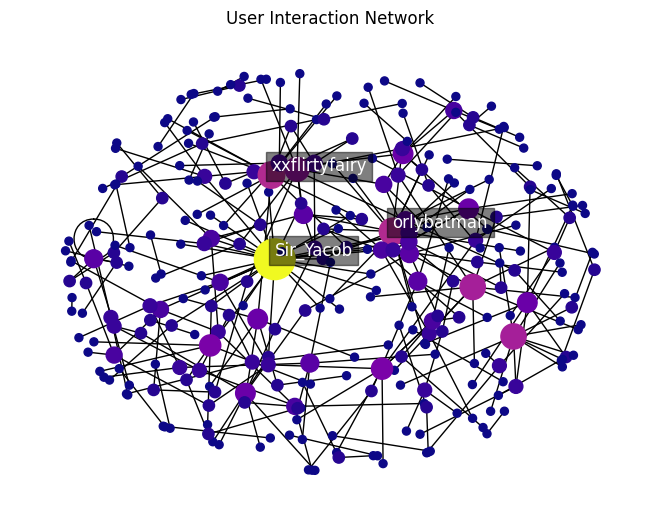

In [ ]:
# 2) User interaction network and highly top 3 users with highest centrality and size of nodes based on centrality

plt.figure()
user_network = create_user_interaction_network(comments_df) # undirected network
pos_users = nx.spring_layout(user_network, k=1, iterations=200) 

degree_centrality = nx.degree_centrality(user_network) # dictionary of degree centrality values for each node
node_color = [degree_centrality[node] for node in user_network.nodes()] # put the degree centrality values into a list in the order of the node ids
node_size = [degree_centrality[node]*10000 for node in user_network.nodes()] # multiply the degree centrality values by 1000 to get the size of the nodes
nx.draw(user_network, pos_users, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma) # colour nodes based on centrality because node_color=node_color

# Label the top 3 nodes by in-degree centrality
top_3_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:3] # get node id of top 3 authors with highest degree centrality

labels = {node: node for node in top_3_nodes} # put names of top 3 authors into a dictionary (key and value is name of author)
nx.draw_networkx_labels(user_network, pos_users, labels=labels, font_color='white', bbox=dict(facecolor='black', alpha=0.5), verticalalignment='bottom', horizontalalignment='left')
plt.title("User Interaction Network")

Text(0.5, 1.0, 'User-Post Network')

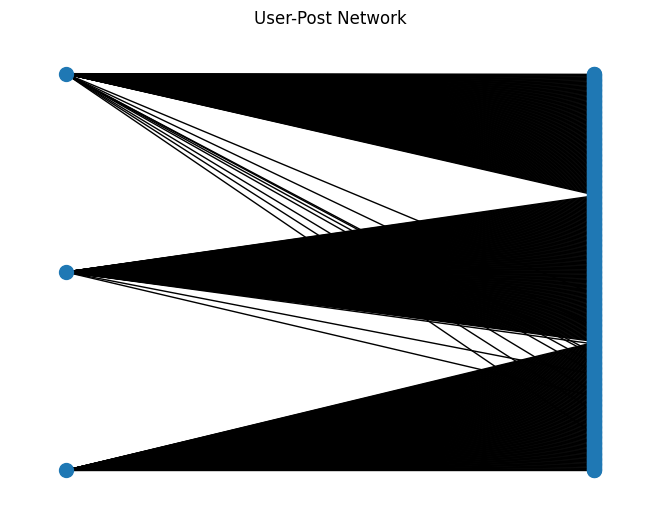

In [ ]:
# 3) Bipartite network - posts on one side and users on the other side (users that have commented on the post)

plt.figure()

bipartite_network = create_user_post_network(comments_df)
pos_bipartite = nx.bipartite_layout(bipartite_network, 
                                   nodes=[n for n, d in bipartite_network.nodes(data=True) 
                                        if d['bipartite']==0])
nx.draw(bipartite_network, pos_bipartite, node_size=100)
plt.title("User-Post Network")

In [33]:
# Create Jaccards similarity score for users that comment among the top 3 users

post_1_comments = comments_df[comments_df['post_id'] == posts[0]['id']]
post_2_comments = comments_df[comments_df['post_id'] == posts[1]['id']]
post_3_comments = comments_df[comments_df['post_id'] == posts[2]['id']]

users_post1=set(post_1_comments['author'])
users_post2=set(post_2_comments['author'])
users_post3=set(post_3_comments['author'])


jaccard_1_2 = jaccard_similarity(users_post1, users_post2)
jaccard_2_3 = jaccard_similarity(users_post2, users_post3)
jaccard_1_3 = jaccard_similarity(users_post1, users_post3)

print(f"Jaccard similarity between users who commented on post 1 and post 2: {jaccard_1_2:.4f}")
print(f"Jaccard similarity between users who commented on post 2 and post 3: {jaccard_2_3:.4f}")
print(f"Jaccard similarity between users who commented on post 1 and post 2: {jaccard_1_3:.4f}")



Jaccard similarity between users who commented on post 1 and post 2: 0.0122
Jaccard similarity between users who commented on post 2 and post 3: 0.0091
Jaccard similarity between users who commented on post 1 and post 2: 0.0266


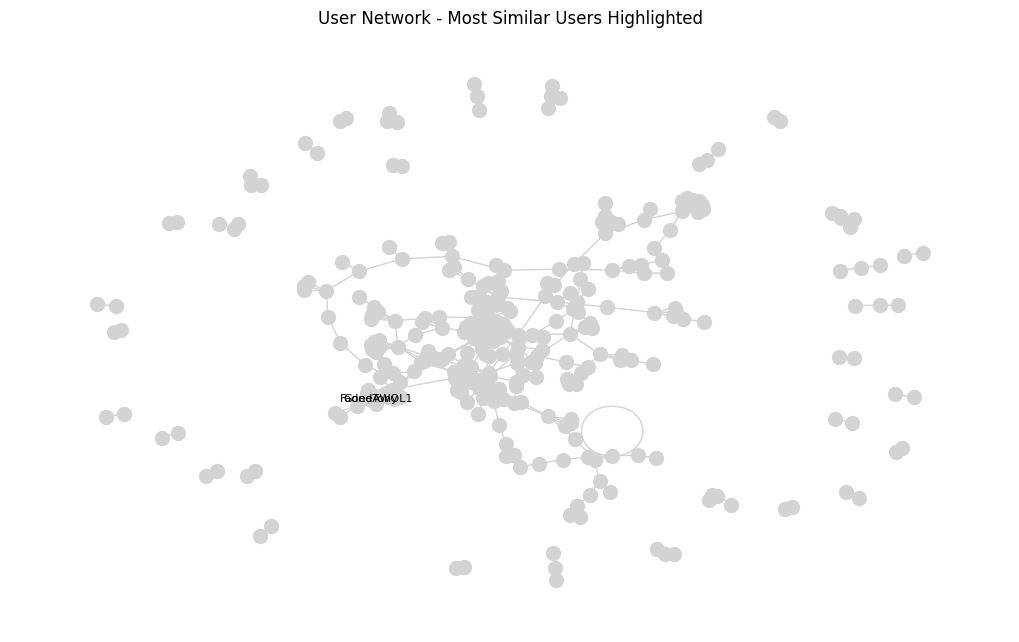

GoneAWOL1 - FadedTony: 1.000


In [38]:
# 4) FInd most similar users
similar_users = find_similar_users(user_network, metric='cosine')
# similar_users = find_similar_users(user_network, metric='jaccard')
# similar_users = find_similar_users(user_network, metric='euclidean')

number_of_similar_users = 1

# Visualize similar pairs
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(user_network)

# Draw full network in gray
nx.draw(user_network, pos, node_color='lightgray', 
        edge_color='lightgray', width=1, node_size=100)

# Highlight similar pairs
for user1, user2, sim in similar_users[:number_of_similar_users]:
    # Draw edge in red with width proportional to similarity
    nx.draw_networkx_edges(user_network, pos, 
                          edgelist=[(user1, user2)],
                          edge_color='red',
                          width=sim*3)
    
    # Label nodes
    nx.draw_networkx_labels(user_network, pos, 
                           labels={user1: user1, user2: user2},
                           font_size=8)

plt.title("User Network - Most Similar Users Highlighted")
plt.show()

# Print similarities
for user1, user2, sim in similar_users[:number_of_similar_users]:
    print(f"{user1} - {user2}: {sim:.3f}")